<center><h1><b> Wadaba Plastic Images Classification </b></h1></center>
<center><h2><b> Distributed Training </b></h2></center>

In [1]:
# Import necessary libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pathlib  # To convert datadirectory into a pathlib that will help to convert each photo into numpy array
import PIL  # This is an image displaying library in python
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint  # to save the best epoch(weights, bias)
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0

In [2]:
# Defining the input path and the output path for images
input_path = '/kaggle/input/wadaba'
output_images_path = '/kaggle/working/wadaba/images'

# To create the output folder for images if it doesn't exist
os.makedirs(output_images_path, exist_ok = True)

# Iterating through each image folder in the input path
for folder_name in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder_name)
    
    # Cofirm it is a folder
    if os.path.isdir(folder_path):
        # Create corresponding folder in the images output directory
        image_dest_folder = os.path.join(output_images_path, folder_name)
        os.makedirs(image_dest_folder, exist_ok = True)
        
        # Extracting images only
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # This is to copy the files into images folder if it an image
            if file_name.endswith('.jpg') and os.path.isfile(file_path):
                shutil.copy(file_path, image_dest_folder)
                
print('Images have been successfully extracted into the images directory.')

Images have been successfully extracted into the images directory.


In [3]:
print(os.listdir(output_images_path))

['PS', 'Other', 'PET', 'PE_HD', 'PP']


In [4]:
# Converting data directory into a pathlib
data_dir = pathlib.Path(output_images_path)
data_dir

PosixPath('/kaggle/working/wadaba/images')

In [5]:
# Check the immediate subdirectories/files
list(data_dir.glob('*'))

[PosixPath('/kaggle/working/wadaba/images/PS'),
 PosixPath('/kaggle/working/wadaba/images/Other'),
 PosixPath('/kaggle/working/wadaba/images/PET'),
 PosixPath('/kaggle/working/wadaba/images/PE_HD'),
 PosixPath('/kaggle/working/wadaba/images/PP')]

In [6]:
# Number of all images with the .jpg extension in all nested directories
len(list(data_dir.glob('**/*.jpg')))

4000

## Visualization of an image from each directory

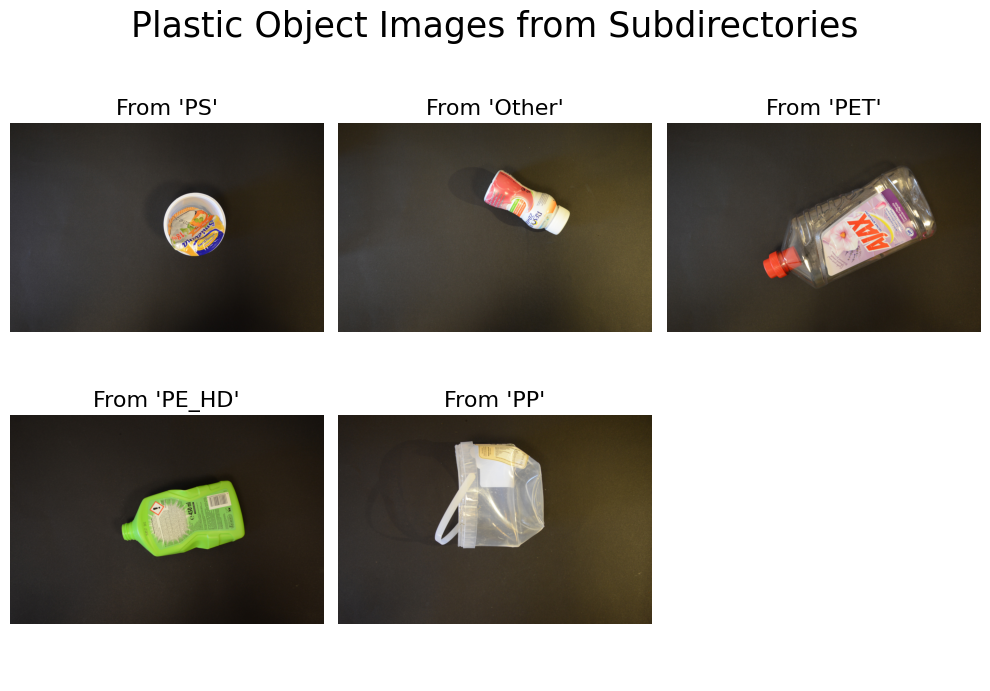

In [7]:
rows = 2
cols = 3

# Set up the subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
fig.suptitle("Plastic Object Images from Subdirectories", fontsize=25)

# Flatten the axes array to easily iterate through it
axes = axes.ravel()

# Counter to keep track of the images displayed
image_count = 0

# Iterate through each subdirectory and display one image from each
for sub_dir in data_dir.iterdir():
    if sub_dir.is_dir():
        image_list = list(sub_dir.glob('*.jpg'))
        if image_list:
            # Open the first image in the subdirectory
            img = Image.open(image_list[0])
            
            # Display the image in the corresponding subplot
            axes[image_count].imshow(img)
            axes[image_count].set_title(f"From '{sub_dir.name}'", fontsize=16)
            axes[image_count].axis('off') 
            
            image_count += 1

# Remove any empty subplots
for ax in axes[image_count:]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [8]:
# Dictionary class for all the plastic object
plastic_images_dict =  {
    'pe_hd': list(data_dir.glob('PE_HD/*')),
    'ps': list(data_dir.glob('PS/*')),
    'other': list(data_dir.glob('Other/*')),
    'pp': list(data_dir.glob('PP/*')),
    'pet': list(data_dir.glob('PET/*'))
}

In [9]:
# Label dictionary
plastic_labels_dict = {
    'pe_hd': 0,
    'ps': 1,
    'other': 2,
    'pp': 3,
    'pet': 4
}

In [10]:
# Runing a for loop to view number of images in each class
for plastic_name, images in plastic_images_dict.items():
    print(f"The directory '{plastic_name}' contains {len(images)} images.")

The directory 'pe_hd' contains 600 images.
The directory 'ps' contains 520 images.
The directory 'other' contains 40 images.
The directory 'pp' contains 640 images.
The directory 'pet' contains 2200 images.


In [19]:
# Function to preprocess images, apply random oversampling, and split the data
def preprocess_and_split_data(plastic_images_dict, plastic_labels_dict, image_size, num_classes, test_size=0.2, random_state=0):
    # Generator function to yield images and labels
    def data_generator(images_dict, labels_dict):
        for plastic_name, images in images_dict.items():
            for image in images:
                img = cv2.imread(str(image))
                if img is not None:
                    resized_img = cv2.resize(img, image_size)
                    yield resized_img / 255.0, labels_dict[plastic_name]

    # Create a TensorFlow Dataset from the generator
    tf_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(plastic_images_dict, plastic_labels_dict),
        output_signature=(tf.TensorSpec(shape=(image_size[0], image_size[1], 3), dtype=tf.float32),
                          tf.TensorSpec(shape=(), dtype=tf.int32))
    )

    # Convert data to numpy arrays for oversampling
    all_images = []
    all_labels = []
    for img, label in tf_dataset:
        all_images.append(img.numpy())
        all_labels.append(label.numpy())

    # Apply Random Oversampling
    ros = RandomOverSampler(random_state=random_state)
    all_images = np.array(all_images).reshape(len(all_images), -1)
    X_resampled, y_resampled = ros.fit_resample(all_images, all_labels)

    # Reshape the images back to the original shape
    X_resampled = X_resampled.reshape(-1, image_size[0], image_size[1], 3)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, random_state=random_state)

    # Convert numpy arrays back to TensorFlow datasets
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
    test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

    return train_tf_dataset, test_tf_dataset

## Building Custom CNN Model

In [20]:
# Function to create the model
def get_model(num_classes=5, learning_rate=0.001, image_size=(180, 180)):
    data_augmentation = tf.keras.Sequential([
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.5),
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal_and_vertical")
    ])

    model = Sequential([
        layers.Input(shape=(image_size[0], image_size[1], 3)),
        data_augmentation,

        # CNN Layers
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense Layers with Dropout
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
# Function to plot training & validation accuracy and loss curves
def plot_training_graphs(model):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='Train Accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'], label='Train Loss')
    plt.plot(model.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend();

#### Custom Model Training Distribution

In [26]:
# Distributed training function
def train_and_evaluate_model(train_dataset, test_dataset, epochs, learning_rate):
    checkpoint_callback = ModelCheckpoint(
        'custom_plastic_images_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    with strategy.scope():
        gpu_model = get_model(learning_rate=learning_rate)
        model_train = gpu_model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[checkpoint_callback])

    best_model = load_model('custom_plastic_images_model.keras')
    loss, accuracy = best_model.evaluate(test_dataset)
    print(f'Best Accuracy: {accuracy * 100:.2f}%')
    print(f'Best Loss: {loss:.4f}')
    
    plot_training_graphs(model_train)
    
    return best_model

Epoch 1/40
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2301 - loss: 1.6083
Epoch 1: val_accuracy improved from -inf to 0.33455, saving model to custom_plastic_images_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.2303 - loss: 1.6079 - val_accuracy: 0.3345 - val_loss: 1.5198
Epoch 2/40
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3223 - loss: 1.4992
Epoch 2: val_accuracy improved from 0.33455 to 0.42727, saving model to custom_plastic_images_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.3226 - loss: 1.4989 - val_accuracy: 0.4273 - val_loss: 1.3224
Epoch 3/40
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4208 - loss: 1.3622
Epoch 3: val_accuracy improved from 0.42727 to 0.54364, saving model to custom_plastic_images_model.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.4211 - loss: 1.3616 - val_accuracy: 0.5436 - val_loss: 1.0408
Epoch 4/40
273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.

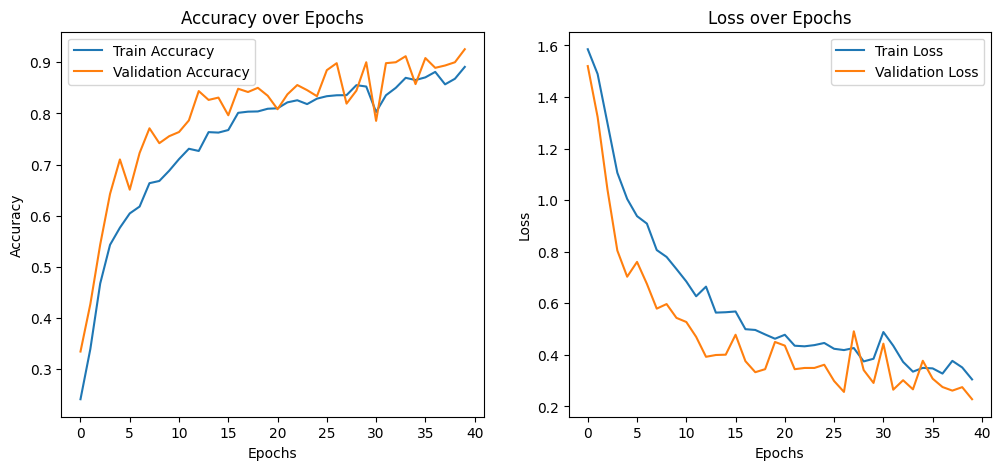

In [27]:
# Parameters
image_size = (180, 180)
num_classes = 5
batch_size_per_replica = 32

# Creating mirror strategy
strategy = tf.distribute.MirroredStrategy()

# Processing and splitting the dataset
train_tf_dataset, test_tf_dataset = preprocess_and_split_data(plastic_images_dict, plastic_labels_dict, image_size, num_classes=num_classes)

# Running distributed training
custom_best_model = train_and_evaluate_model(train_tf_dataset, test_tf_dataset, epochs=40, learning_rate=0.001)

## Making predictions and displaying the predicted images and the actual images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


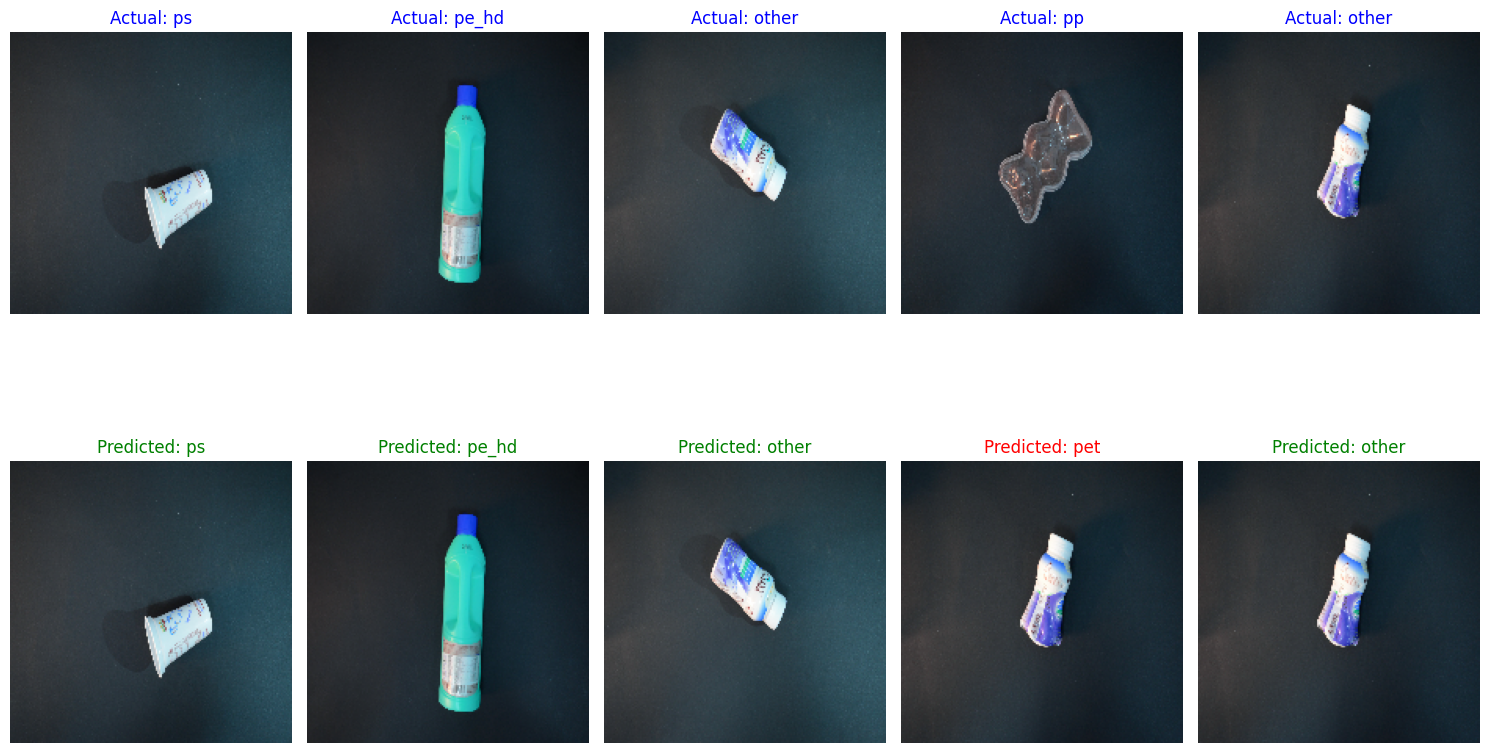

In [28]:
# Function to compare predicted and actual images with label-specific images
def predictions_and_actuals(model, test_dataset, labels_dict, num_images=5):
    # Create a reverse mapping from numeric labels to string labels
    reverse_labels_dict = {v: k for k, v in labels_dict.items()}

    # Initialize lists to store images, predictions, and actual labels
    predicted_images, actual_images, predictions, actuals = [], [], [], []
    
    # Iterate over the test dataset to gather images and labels up to num_images
    for batch, (X_test_batch, y_test_batch) in enumerate(test_dataset):
        if len(predicted_images) >= num_images:
            break

        # Predict classes for the batch
        batch_predictions = model.predict(X_test_batch)
        predicted_classes = np.argmax(batch_predictions, axis=1)

        # Collect predicted and actual images based on labels
        for i in range(len(X_test_batch)):
            if len(predicted_images) >= num_images:
                break
            
            # Get images based on predicted and actual classes
            predicted_image = X_test_batch[i].numpy()
            actual_image = X_test_batch[i].numpy()
            if predicted_classes[i] != y_test_batch[i].numpy():
                # If labels differ, use different images for prediction and actual
                predicted_image = X_test_batch[predicted_classes[i]].numpy()
                actual_image = X_test_batch[y_test_batch[i].numpy()].numpy()

            # Append images and labels to corresponding lists
            predicted_images.append(predicted_image)
            actual_images.append(actual_image)
            predictions.append(predicted_classes[i])
            actuals.append(y_test_batch[i].numpy())

    # Display images with label-specific images
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        
         # Display actual image with actual label
        plt.subplot(2, num_images, i + 1)
        img_actual = actual_images[i]
        img_actual = (img_actual * 255).astype('uint8') if np.max(img_actual) <= 1.0 else img_actual
        plt.imshow(img_actual)
        plt.axis('off')
        plt.title(f'Actual: {reverse_labels_dict[actuals[i]]}', color="blue")
        
        # Display predicted image with predicted label
        plt.subplot(2, num_images, i + 1 + num_images)
        img_pred = predicted_images[i]
        img_pred = (img_pred * 255).astype('uint8') if np.max(img_pred) <= 1.0 else img_pred
        plt.imshow(img_pred)
        plt.axis('off')
        plt.title(f'Predicted: {reverse_labels_dict[predictions[i]]}', color="green" if predictions[i] == actuals[i] else 'red')
    
    plt.tight_layout()
    plt.show()

# Call the function to display predicted and actual labels with label-specific images
predictions_and_actuals(custom_best_model, test_tf_dataset, plastic_labels_dict) 

## Classification Report and Confusion Matrix Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

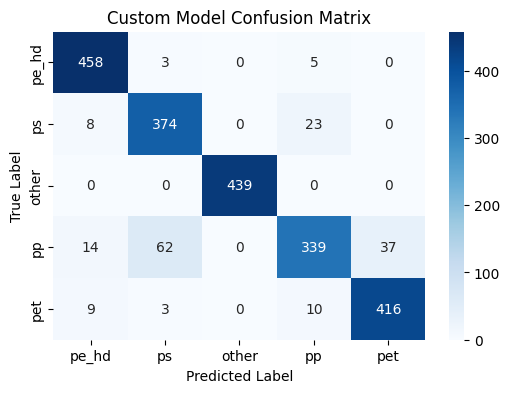

In [29]:
# Function to generate classification report and confusion matrix
def class_report_and_con_matrix(model, test_dataset, labels_dict):
    # Initialize lists to store true labels and predictions
    true_labels, predicted_classes = [], []

    # Iterate over the test dataset
    for X_batch, y_batch in test_dataset:
        # Predict classes for the batch
        predictions = model.predict(X_batch)
        predicted_classes_batch = np.argmax(predictions, axis=1)
        
        # Store true labels and predicted classes
        true_labels.extend(y_batch.numpy())  # Convert to numpy for easier handling
        predicted_classes.extend(predicted_classes_batch)

    # Print classification report
    print("Classification Report:")
    print(classification_report(true_labels, predicted_classes, target_names=labels_dict.keys()))
    print("****" * 15)

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_classes)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_dict.keys(), yticklabels=labels_dict.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Custom Model Confusion Matrix')
    plt.show()

# Load the best model saved by ModelCheckpoint
custom_best_model = load_model('custom_plastic_images_model.keras')

# Call the function to generate the classification report and confusion matrix
class_report_and_con_matrix(custom_best_model, test_tf_dataset, plastic_labels_dict)


In [30]:
# Function to calculate overall precision, recall, F1-score, and accuracy
def model_metrics(model, test_dataset):
    # Initialize lists to store true labels and predictions
    true_labels, predicted_classes = [], []

    # Iterate over the test dataset
    for X_batch, y_batch in test_dataset:
        # Predict on the current batch
        y_pred = model.predict(X_batch)
        
        # Convert probabilities to class labels (for multi-class classification)
        predicted_classes_batch = np.argmax(y_pred, axis=1)

        # Store true labels and predicted classes
        true_labels.extend(y_batch.numpy())  # Convert to numpy for easier handling
        predicted_classes.extend(predicted_classes_batch)

    # Calculate overall metrics
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes, average='macro')
    recall = recall_score(true_labels, predicted_classes, average='macro')
    f1 = f1_score(true_labels, predicted_classes, average='macro')

    # Printing the results
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

# Call the function to calculate and print model metrics
model_metrics(custom_best_model, test_tf_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

(0.9209090909090909,
 0.9200571405929663,
 0.9212122195293849,
 0.9187828577276113)

------------------------------

<center><h2> MobileNet Model</h2></center>

In [31]:
# Function to preprocess images and split the data without oversampling
def preprocess_and_split_data(plastic_images_dict, plastic_labels_dict, image_size, test_size=0.2, random_state=0):
    """
    Datase oversampling is removed from this function.The function processes images by resizing with cv2, 
    converting to a TensorFlow dataset, and splits the dataset into train_tf_dataset and test_tf_dataset.
    """
    def data_generator(images_dict, labels_dict):
        for plastic_name, images in images_dict.items():
            for image in images:
                img = cv2.imread(str(image))
                if img is not None:
                    resized_img = cv2.resize(img, image_size)
                    yield resized_img / 255.0, labels_dict[plastic_name]

    tf_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(plastic_images_dict, plastic_labels_dict),
        output_signature=(tf.TensorSpec(shape=(image_size[0], image_size[1], 3), dtype=tf.float32),
                          tf.TensorSpec(shape=(), dtype=tf.int32))
    )

    all_images, all_labels = [], []
    for img, label in tf_dataset:
        all_images.append(img.numpy())
        all_labels.append(label.numpy())

    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=test_size, random_state=random_state)

    train_tf_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
    test_tf_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

    return train_tf_dataset, test_tf_dataset 

In [32]:
# Function to create a model with a customizable pretrained base model
def build_model(base_model, num_classes=5, learning_rate=0.001, image_size=(224, 224)):
    data_augmentation = tf.keras.Sequential([
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.5),
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal_and_vertical")
    ])

    base_model.trainable = False

    model = Sequential([
        layers.Input(shape=(image_size[0], image_size[1], 3)),
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model 

In [33]:
# Distributed training function with checkpoint filename consistency
def train_and_evaluate_model(train_dataset, test_dataset, base_model, epochs, learning_rate):
    # Generate checkpoint filename using the base model's name
    model_name = base_model.name.lower()
    checkpoint_filename = f'{model_name}_best_model.keras'

    # ModelCheckpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        checkpoint_filename,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    with strategy.scope():
        # Build and compile the model within the distributed strategy's scope
        gpu_model = build_model(base_model=base_model, learning_rate=learning_rate)
        model_train = gpu_model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=test_dataset,
            callbacks=[checkpoint_callback]
        )

    # Load and evaluate the best model saved during training
    best_model = load_saved_model(base_model)
    if best_model:
        loss, accuracy = best_model.evaluate(test_dataset)
        print(f'Best Accuracy: {accuracy * 100:.2f}%')
        print(f'Best Loss: {loss:.4f}')
    
    # Plot training graphs for accuracy and loss
    plot_training_graphs(model_train)

In [34]:
# Function to load saved model with filename consistency
def load_saved_model(base_model):
    # Generate the filename using the base model's class name
    model_name = base_model.name.lower()
    model_filename = f'{model_name}_best_model.keras'

    # Load the saved model from file
    try:
        model = load_model(model_filename)
        print(f'Successfully loaded {model_name} model.')
        return model
    except OSError:
        print(f'Model file {model_filename} not found.')
        return None

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5229 - loss: 1.4220
Epoch 1: val_accuracy improved from -inf to 0.73750, saving model to mobilenetv2_1.00_224_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.5238 - loss: 1.4191 - val_accuracy: 0.7375 - val_loss: 0.6315
Epoch 2/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7109 - loss: 0.7646
Epoch 2: val_accuracy improved from 0.73750 to 0.74000, saving model to mobilenetv2_1.00_224_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.7109 - loss: 0.7644 - val_accuracy: 0.7400 - val_loss: 0.5847
Epoch 3/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7366 - loss: 0.6835
Epoch 3: val_accuracy improved from 0.74000 to 0.82250, saving model to mobilenetv2_1.00_224_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7367 - loss: 0.6831 - val_accuracy: 0.8225 - val_loss: 0.4834
Epoch 4/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - a

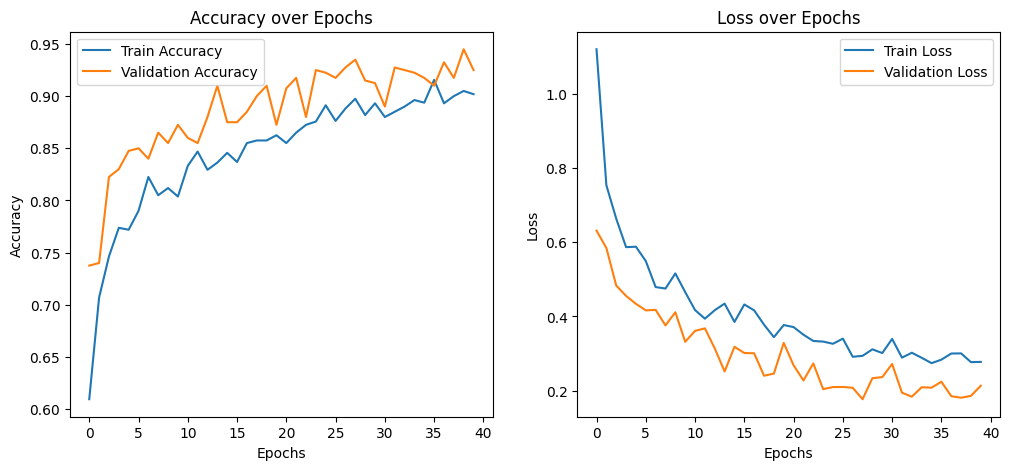

In [35]:
# Parameters
image_size = (224, 224)
epochs = 40
learning_rate = 0.001
num_classes = 5

# Creating distributed training strategy
strategy = tf.distribute.MirroredStrategy()

# Processing and splitting the dataset (assuming `plastic_images_dict` and `plastic_labels_dict` are defined)
train_tf_dataset, test_tf_dataset = preprocess_and_split_data(plastic_images_dict, plastic_labels_dict, image_size)

# 1. Using MobileNetV2 as the base model
mobilenet_base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
train_and_evaluate_model(train_tf_dataset, test_tf_dataset, mobilenet_base_model, epochs, learning_rate)

## Mobilenet Model Prediction, and metrics

Successfully loaded mobilenetv2_1.00_224 model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


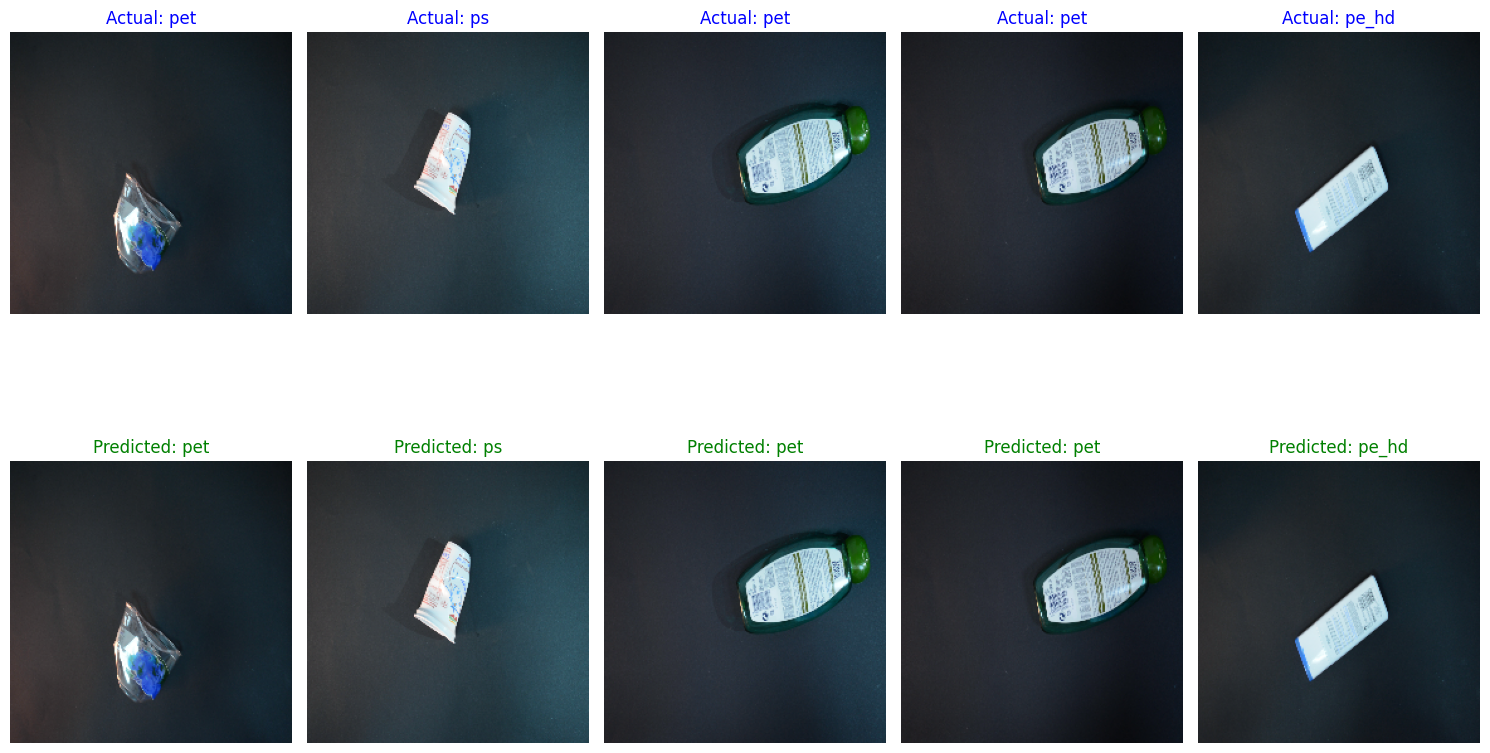

In [36]:
# Loading MobileNet base model
mobilenet_loaded_model = load_saved_model(mobilenet_base_model)

predictions_and_actuals(mobilenet_loaded_model,test_tf_dataset, plastic_labels_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classification Report:
              precision    

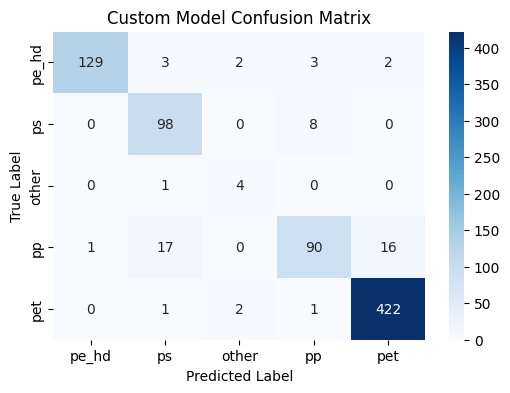

In [37]:
# Mobilenet classification report and confusion matrix
class_report_and_con_matrix(mobilenet_loaded_model, test_tf_dataset, plastic_labels_dict)

In [38]:
# Mobilenet model metrics
model_metrics(mobilenet_loaded_model, test_tf_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 92.88%
Precision: 0.8301
Recall: 0.8738


(0.92875, 0.8300836418483477, 0.8738005272190057, 0.8425610158382953)

-------------------------------

<center><h2> ResNet50 Model</h2></center>

Epoch 1/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4365 - loss: 1.5013
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to resnet50_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.4371 - loss: 1.5002 - val_accuracy: 0.5375 - val_loss: 1.2655
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5179 - loss: 1.3192
Epoch 2: val_accuracy did not improve from 0.53750
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.5181 - loss: 1.3189 - val_accuracy: 0.5375 - val_loss: 1.2382
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5516 - loss: 1.2799
Epoch 3: val_accuracy did not improve from 0.53750
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.5517 - loss: 1.2797 - val_accuracy: 0.5375 - val_loss: 1.2705
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5472 - loss: 1.2808
Epoch 4: val_accuracy did not improve from 0.53750
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step 

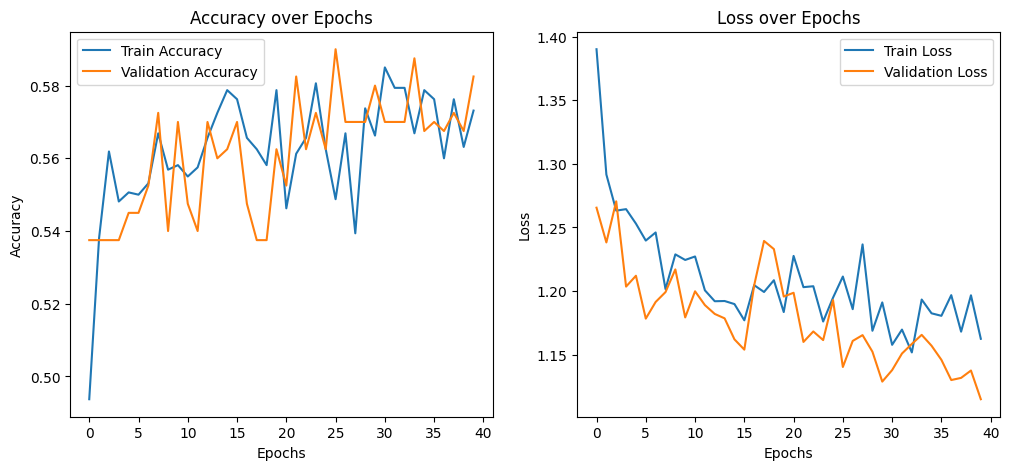

In [39]:
# 2. Using ResNet50 as the base model
resnet_base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
train_and_evaluate_model(train_tf_dataset, test_tf_dataset, resnet_base_model, epochs, learning_rate)

## ResNet50 Model Prediction, and metrics

Successfully loaded resnet50 model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


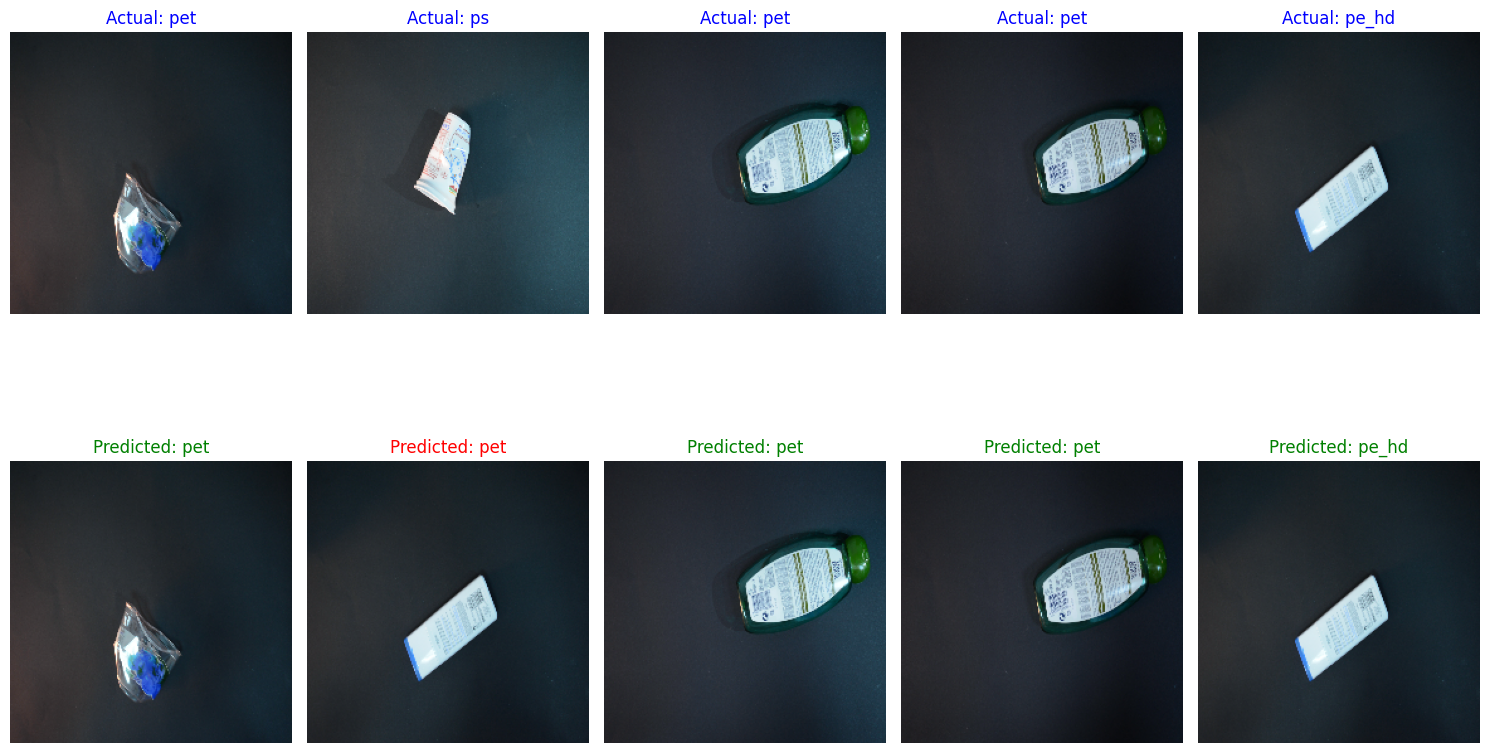

In [40]:
# Resnet50 best model saved by ModelCheckpoint will be loaded
resnet_loaded_model = load_saved_model(resnet_base_model)

# Displaying predictions and labels
predictions_and_actuals(resnet_loaded_model, test_tf_dataset, plastic_labels_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Classification Report:
              precision    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


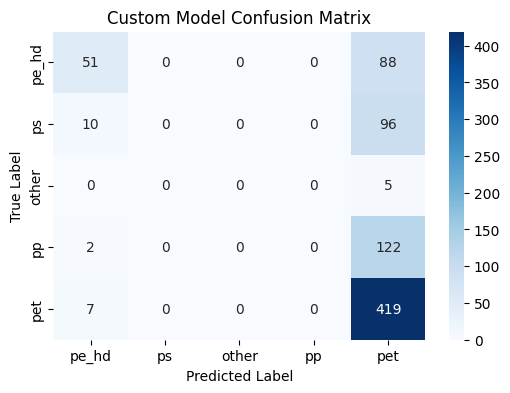

In [41]:
class_report_and_con_matrix(resnet_loaded_model, test_tf_dataset, plastic_labels_dict)

In [42]:
model_metrics(resnet_loaded_model, test_tf_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Accuracy: 58.75%
Precision: 0.2605
Recall: 0.2701


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5875, 0.26050880626223094, 0.27009490998750296, 0.24259035446433005)

-----------------------

<center><h2> EfficientNet Model</h2></center>

Epoch 1/40


2024-10-28 17:43:06.241227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_424/cond/StatefulPartitionedCall/replica_1/sequential_13_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5055 - loss: 1.3911
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to efficientnetb0_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step - accuracy: 0.5058 - loss: 1.3905 - val_accuracy: 0.5375 - val_loss: 1.2489
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5391 - loss: 1.2943
Epoch 2: val_accuracy did not improve from 0.53750
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5394 - loss: 1.2940 - val_accuracy: 0.5375 - val_loss: 1.2435
Epoch 3/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5402 - loss: 1.2865
Epoch 3: val_accuracy did not improve from 0.53750
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5404 - loss: 1.2862 - val_accuracy: 0.5375 - val_loss: 1.2451
Epoch 4/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5453 - loss: 1.2725
Epoch 4: val_accuracy did not improve from 0.53750
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accura

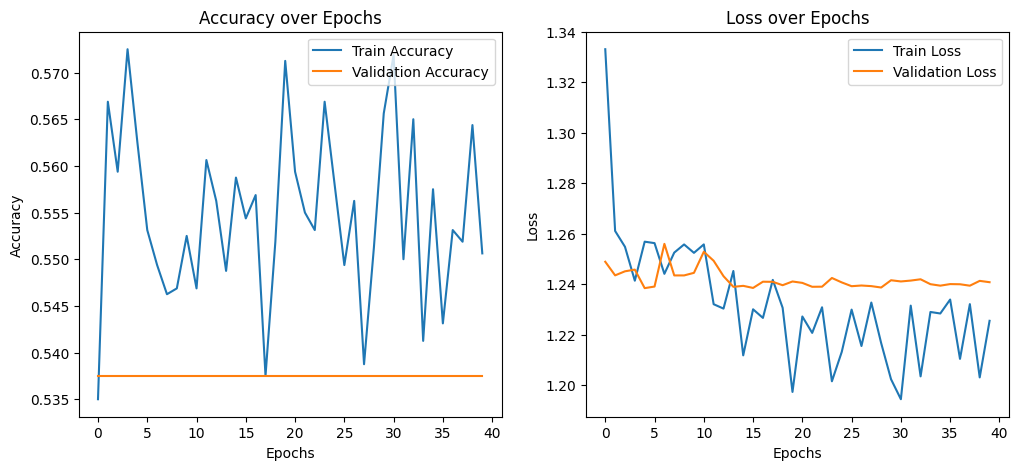

In [43]:
# Using EfficientNetB0 as the base model
efficientnet_base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
train_and_evaluate_model(train_tf_dataset, test_tf_dataset, efficientnet_base_model, epochs, learning_rate)

## EfficientNet Model Prediction, and metrics

Successfully loaded efficientnetb0 model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


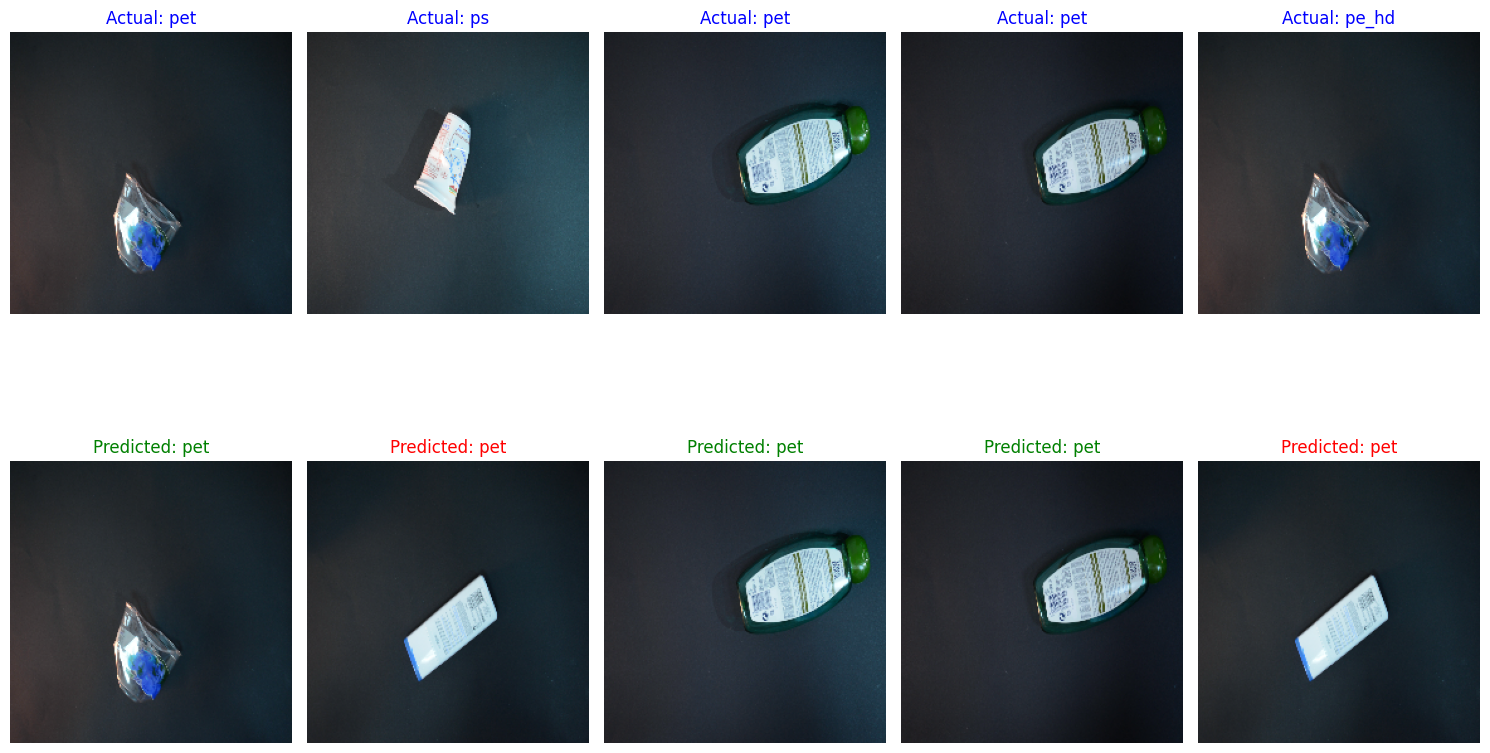

In [44]:
# Efficient best model saved by ModelCheckpoint will be loaded
efficient_loaded_model = load_saved_model(efficientnet_base_model)

# Displaying predictions and labels
predictions_and_actuals(efficient_loaded_model, test_tf_dataset, plastic_labels_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Classification Report:
              precision    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


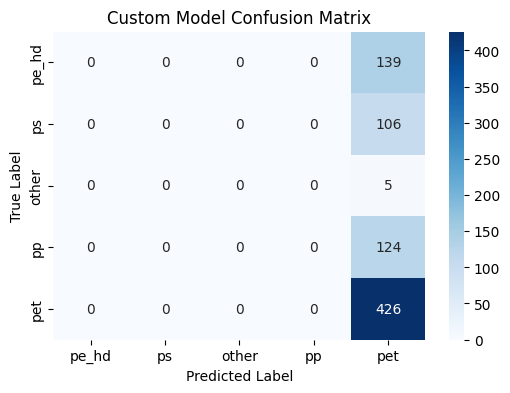

In [45]:
# classification report and confusion matrix for efficient model
class_report_and_con_matrix(efficient_loaded_model, test_tf_dataset, plastic_labels_dict)

In [46]:
# Efficiant model evaluation metrics
model_metrics(efficient_loaded_model, test_tf_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Accuracy: 53.25%
Precision: 0.1065
Recall: 0.2000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5325, 0.1065, 0.2, 0.13898858075040782)